
**The Datasets¶**


We are going to test Isolation Forest (IF), python implementation of which is available in scikit-learn 0.18, on two real datasets from kddcup99. 

The datasets are the two versions (SA and SF) of the tcpdump portions of the 1998 DARPA off-line Intrusion Detection System dataset, created by MIT Lincoln Lab in 1999.

Full dataset description available at http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_kddcup99.html#sklearn.datasets.fetch_kddcup99


SA is obtained by simply selecting all the normal data, and a small proportion of abnormal data to give an anomaly ratio of 1%. SA has all 41 attributes.

SF is the data where attribute logged_in is positive, thus focusing on the intrusion attack, which gives an anomaly ratio 0.3%. SF has log-transformed 4 attributes.


we are going to implement and show results on SF dataset



**importing dataset**

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [ ]:
sf = datasets.fetch_kddcup99(subset='SF', percent10=True)

**defining features and targets**

In [ ]:
import pandas as pd
dfsf=pd.DataFrame(sf.data,columns=["duration", "service", "src_bytes", "dst_bytes"])

In [ ]:
dfsf['target']=sf.target
dfsf['target'].value_counts()

b'normal.'             69939
b'back.'                2203
b'warezclient.'         1020
b'buffer_overflow.'       30
b'loadmodule.'             8
b'ftp_write.'              6
b'satan.'                  6
b'rootkit.'                5
b'multihop.'               4
b'ipsweep.'                4
b'phf.'                    4
b'perl.'                   3
b'warezmaster.'            2
b'guess_passwd.'           1
b'spy.'                    1
b'imap.'                   1
Name: target, dtype: int64

In [ ]:
dfsf_bkp=dfsf.copy()

**defining anomoly rate**

In [ ]:
#defining anomoly rate
anamoly_rate= 1-(len(dfsf_bkp.loc[dfsf_bkp['target']==b'normal.']) / len(dfsf_bkp))
print("anamoly rate is {}".format(anamoly_rate))

anamoly rate is 0.04503188279148518


**data preprocessing : encoding & normalisation**

In [ ]:
dfsf['binary_target']=[1 if x==b'normal.' else -1 for x in dfsf['target']]

from sklearn import preprocessing
leSf=preprocessing.LabelEncoder()

def byte_decoder(val):
    # decodes byte literals to strings
    return val.decode('utf-8')

toDecodeSF = ['service', 'target']

for f in toDecodeSF:
  dfsf[f] = list(map(byte_decoder, dfsf[f]))
  dfsf[f] = leSf.fit_transform( dfsf[f])

dfsf_normed=preprocessing.normalize(dfsf.drop(['target', 'binary_target'],axis=1))

In [ ]:
print(dfsf_normed.shape)
dfsf_normed

(73237, 4)


array([[-0.17641854,  0.61294077,  0.39833867,  0.65917101],
       [-0.19631525,  0.68206905,  0.46695146,  0.52744522],
       [-0.18742607,  0.65118487,  0.44443456,  0.58592462],
       ...,
       [-0.18939444,  0.65802367,  0.43706742,  0.58318665],
       [-0.18691023,  0.64939265,  0.4605547 ,  0.57553724],
       [-0.18862485,  0.65534986,  0.44150333,  0.58310551]])

**split into train & test datasets**

In [ ]:
X_train_sf,X_test_sf,y_train_sf,y_test_sf = train_test_split(dfsf_normed,dfsf['binary_target'],test_size=0.33,random_state=11)
print(X_train_sf.shape)
print(X_test_sf.shape)
print(y_train_sf.shape)
print(y_test_sf.shape)

(49068, 4)
(24169, 4)
(49068,)
(24169,)


Train Isolation Forest and LOF (same parameters):

num_estimators = 100

max_samples = 75%

contamination = 15%

**Define and Fit Model**

We'll create a model variable and instantiate the IsolationForest class. We are passing the values of four parameters to the Isolation Forest method, listed below.


**Number of estimators:** n_estimators refers to the number of base estimators or trees in the ensemble, i.e. the number of trees that will get built in the forest. This is an integer parameter and is optional. The default value is 100.


**Max samples:** max_samples is the number of samples to be drawn to train each base estimator. If max_samples is more than the number of samples provided, all samples will be used for all trees. The default value of max_samples is 'auto'. If 'auto', then max_samples=min(256, n_samples)


**Contamination:** This is a parameter that the algorithm is quite sensitive to; it refers to the expected proportion of outliers in the data set. This is used when fitting to define the threshold on the scores of the samples. The default value is 'auto'. If ‘auto’, the threshold value will be determined as in the original paper of Isolation Forest.


**Max features:** All the base estimators are not trained with all the features available in the dataset. It is the number of features to draw from the total features to train each base estimator or tree.The default value of max features is one.

In [ ]:
from sklearn.ensemble import IsolationForest
import datetime
clfIF = IsolationForest(max_samples=0.75, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)

start=datetime.datetime.now()
clfIF.fit(X_train_sf,y_train_sf)

y_pred_ts=clfIF.predict(X_test_sf)
end=datetime.datetime.now()
print (end-start)

0:00:05.026911


**classification reports**

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print("classification score : ", accuracy_score(y_test_sf, y_pred_ts))

print("classification error : ", 1-accuracy_score(y_test_sf, y_pred_ts))

print("\n\nclassification report ::\n",classification_report(y_test_sf,y_pred_ts))
print ("\n\nAUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_ts)))

classification score :  0.8379742645537672
classification error :  0.16202573544623278


classification report ::
               precision    recall  f1-score   support

          -1       0.11      0.36      0.17      1073
           1       0.97      0.86      0.91     23096

    accuracy                           0.84     24169
   macro avg       0.54      0.61      0.54     24169
weighted avg       0.93      0.84      0.88     24169



AUC:  61.0%


**confusin matrix**

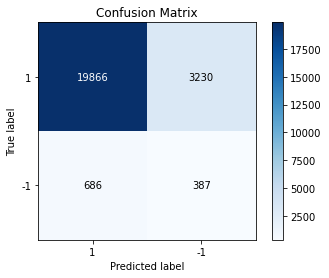

In [ ]:
!pip install scikit-plot
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test_sf.values, y_pred_ts ,labels=[1,-1])# -1 is anamoly and 1 is normal as target variable defined.


**More efficient parameter tuning using GridSearchCV**

Searching multiple parameters simultaneously

In [ ]:
from sklearn.metrics import  precision_recall_curve, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
import numpy as np

start=datetime.datetime.now()

max_samples=[0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.80,0.85,0.90]
anamoly_rate=format(float(anamoly_rate),".3f")
contamination=np.linspace(float(anamoly_rate),0.20)

contamination=list(set([round(i,2) for i in  contamination if round(i,2) > 0.04]))

print("contamination : ",contamination)
print("max_samples : ",max_samples)

#defining scorers for model
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

param_grid=dict(max_samples=max_samples,contamination=contamination)
print(param_grid)

from sklearn.model_selection import GridSearchCV

refit_score='recall_score' #this is to make sure best parameter is chosen such that it gives highest recall value
grid = GridSearchCV(clfIF, param_grid, cv=10, scoring=scorers,refit=refit_score)
grid.fit(X_train_sf,y_train_sf)
end=datetime.datetime.now()

print("\n\ntotal time for trainin is ,",end)

contamination :  [0.05, 0.07, 0.09, 0.08, 0.06, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.19, 0.18, 0.2, 0.16]
max_samples :  [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.9]
{'max_samples': [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.9], 'contamination': [0.05, 0.07, 0.09, 0.08, 0.06, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.19, 0.18, 0.2, 0.16]}


total time for trainin is , 2021-05-25 18:07:46.916659


In [ ]:
print("total time required for training is ",end-start)

total time required for training is  1:29:02.810374


**best parameters after grid search**

In [ ]:
print(grid.best_score_) #this is for best recall_score as refit_score was recall_score
print(grid.best_params_)
print(grid.best_estimator_)

0.9541455227226306
{'contamination': 0.05, 'max_samples': 0.5}
IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples=0.5, n_estimators=100, n_jobs=-1,
                random_state=11, verbose=0, warm_start=False)


**Using the best parameters to make predictions**

**Classification Accuracy** Overall, how often is the classifier correct?



**Classification Error:** Overall, how often is the classifier incorrect?


**Sensitivity:** When the actual value is positive, how often is the prediction correct?
Also known as "True Positive Rate" or ***Recall***



**Specificity**: When the actual value is negative, how often is the prediction correct?



**Precision**: When a positive value is predicted, how often is the prediction correct?


Best params for recall_score
{'contamination': 0.05, 'max_samples': 0.5}

recall score: 0.9541455227226306

training with best parametrs that grid search has found

classification score :  0.9184492531755555
classification error :  0.08155074682444452


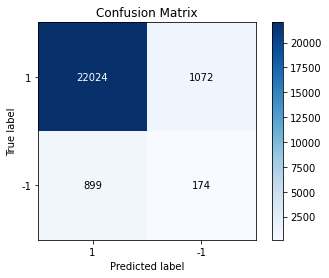

In [ ]:
print('Best params for {}'.format(refit_score))
print(grid.best_params_)

print("\nrecall score:",grid.best_score_)

print("\ntraining with best parametrs that grid search has found\n")
clfIF = IsolationForest(max_samples=0.5, random_state=11, contamination =  0.05, n_estimators=100, n_jobs=-1)
clfIF.fit(X_train_sf,y_train_sf)

#y_pred = grid.predict(X_test_sf), same as below, grid has now best parameters saved
y_pred_ts=clfIF.predict(X_test_sf)

print("classification score : ", accuracy_score(y_test_sf, y_pred_ts))

print("classification error : ", 1-accuracy_score(y_test_sf, y_pred_ts))

skplt.metrics.plot_confusion_matrix(y_test_sf.values, y_pred_ts ,labels=[1,-1])

**list of all parameters combination and mean test score by grid search**

In [ ]:
results=pd.DataFrame(grid.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score','params']]

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,params
2,0.960152,0.954146,0.918419,"{'contamination': 0.05, 'max_samples': 0.5}"
0,0.960235,0.954145,0.918501,"{'contamination': 0.05, 'max_samples': 0.4}"
5,0.959874,0.953911,0.917930,"{'contamination': 0.05, 'max_samples': 0.65}"
1,0.959951,0.953761,0.917869,"{'contamination': 0.05, 'max_samples': 0.45}"
4,0.959847,0.953718,0.917726,"{'contamination': 0.05, 'max_samples': 0.6}"
...,...,...,...,...
147,0.964170,0.807103,0.787214,"{'contamination': 0.2, 'max_samples': 0.8}"
145,0.964157,0.806826,0.786949,"{'contamination': 0.2, 'max_samples': 0.65}"
146,0.964152,0.806655,0.786786,"{'contamination': 0.2, 'max_samples': 0.7}"
148,0.964121,0.806013,0.786174,"{'contamination': 0.2, 'max_samples': 0.85}"


Sensitivity and specificity are inversely proportional, meaning that as the sensitivity increases, the specificity decreases and vice versa.

**trying to get maximum anamolies detected**


Isolation forest works on the principle of the decision tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the maximum and minimum values of the selected feature. This random partitioning of features will produce smaller paths in trees for the anomalous data values and distinguish them from the normal set of the data.

so as per this defination trying to take minimum number of samples to detect outlier easilly

classification score :  0.8453804460259009
classification error :  0.1546195539740991


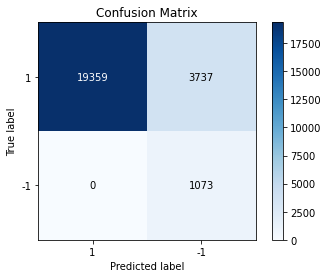

In [ ]:
#testing accuracy with below parametrs
clfIF = IsolationForest(max_samples=0.20, random_state=11, contamination =  0.20, n_estimators=100, n_jobs=-1)
clfIF.fit(X_train_sf,y_train_sf)

#y_pred = grid.predict(X_test_sf), same as below, grid has now best parameters saved
y_pred_ts=clfIF.predict(X_test_sf)

print("classification score : ", accuracy_score(y_test_sf, y_pred_ts))

print("classification error : ", 1-accuracy_score(y_test_sf, y_pred_ts))

skplt.metrics.plot_confusion_matrix(y_test_sf.values, y_pred_ts ,labels=[1,-1])

classification score :  0.845337083231434
classification error :  0.15466291676856603


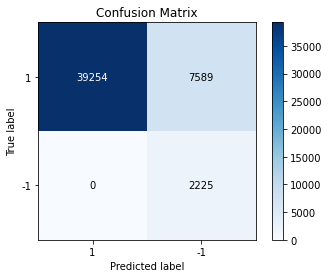

In [ ]:
#training accuracy with below parametrs
clfIF = IsolationForest(max_samples=0.20, random_state=11, contamination =  0.20, n_estimators=100, n_jobs=-1)
clfIF.fit(X_train_sf,y_train_sf)

#y_pred = grid.predict(X_test_sf), same as below, grid has now best parameters saved
y_pred_ts=clfIF.predict(X_train_sf)

print("classification score : ", accuracy_score(y_train_sf, y_pred_ts))

print("classification error : ", 1-accuracy_score(y_train_sf, y_pred_ts))

skplt.metrics.plot_confusion_matrix(y_train_sf.values, y_pred_ts ,labels=[1,-1])